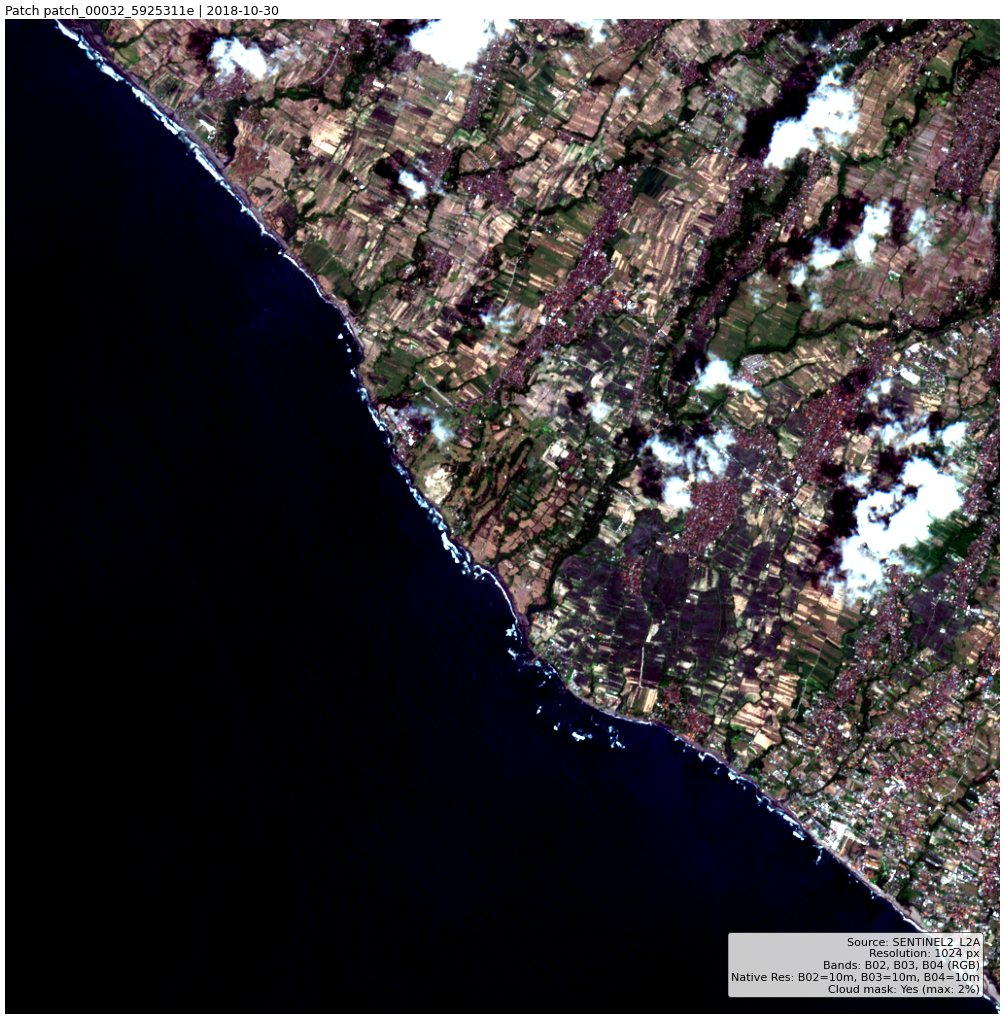

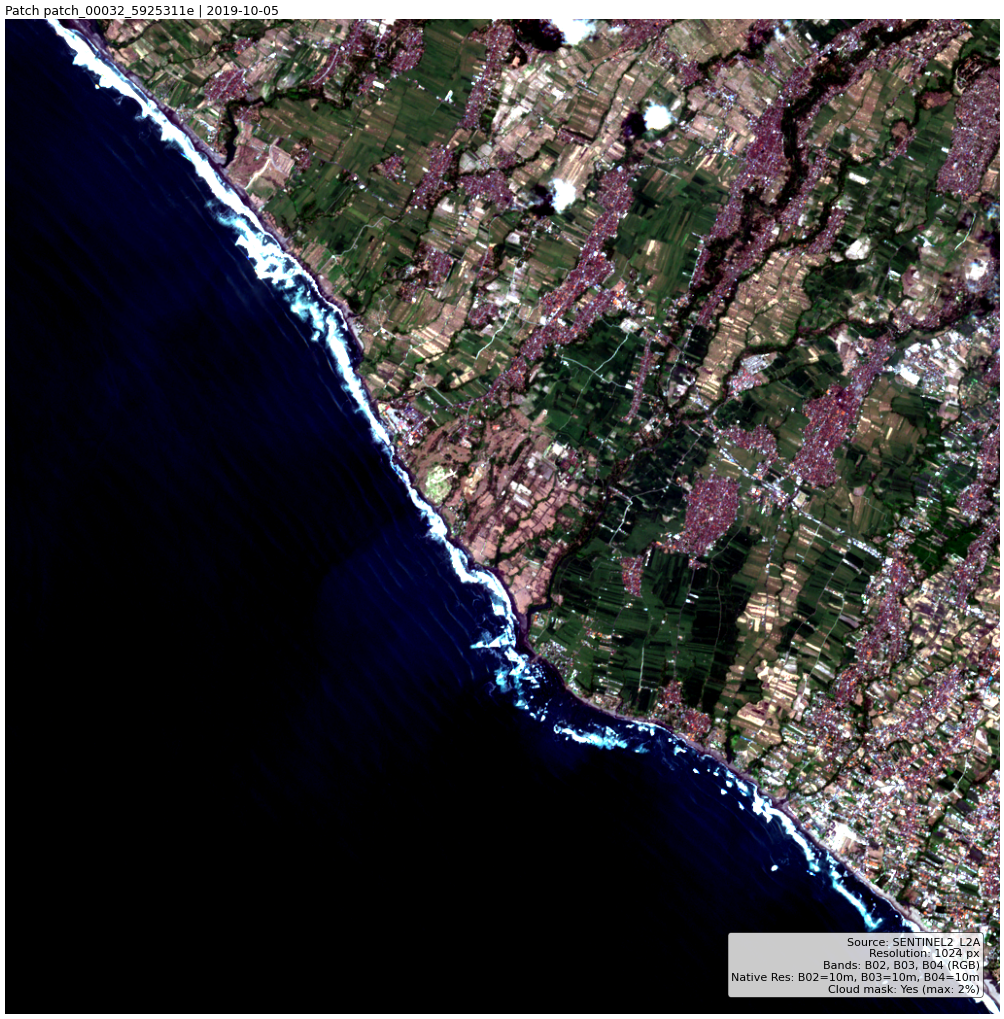

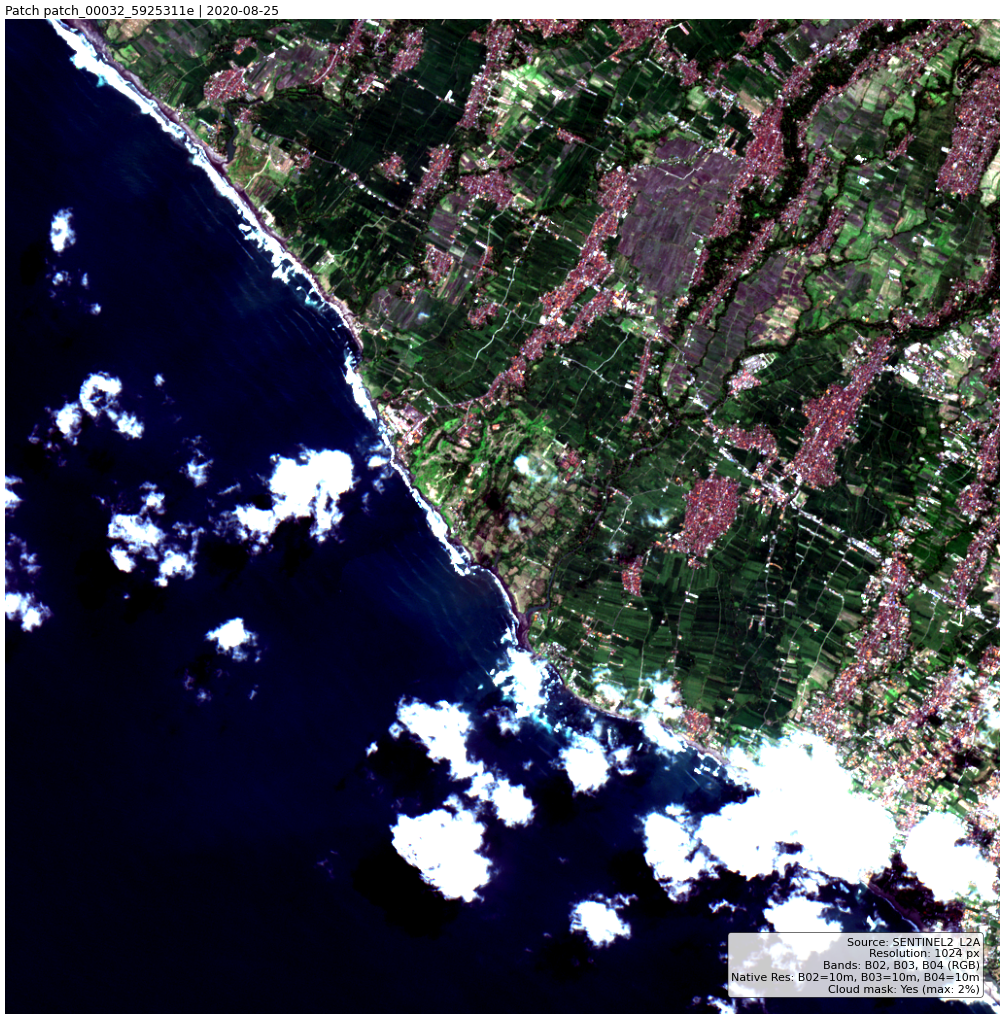

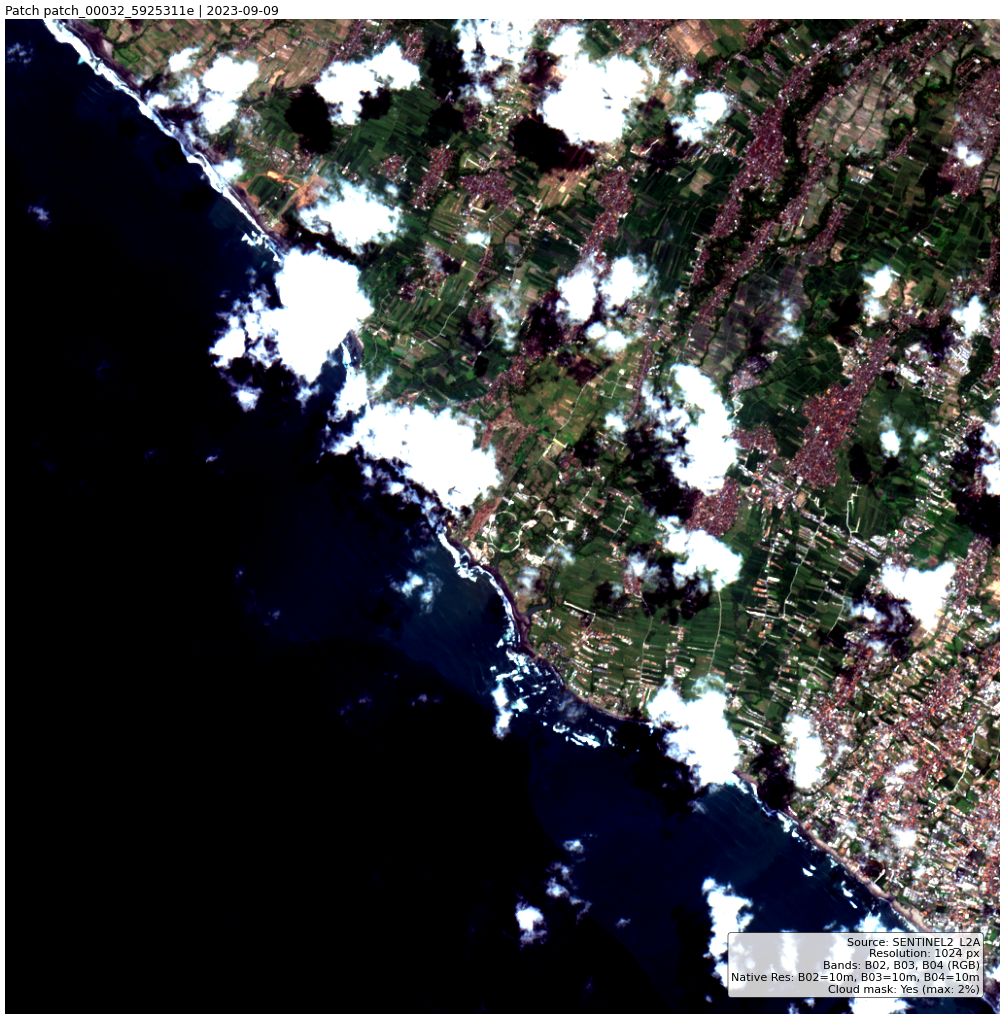

In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from glob import glob

# Directory containing your TIFFs
folder = "../data/processed/sentinel2"

# Load all .tiff files
tiff_files = sorted(glob(os.path.join(folder, "*.tiff")))

# DPI setting for actual pixel display
dpi = 50

for path in tiff_files:
    img = tifffile.imread(path)
    img_transpose = np.transpose(img, (1, 2, 0))  # (bands, height, width) → (H, W, C)

    # Extract RGB: Bands 4, 3, 2 (0-based indices)
    rgb = img_transpose[:, :, [3, 2, 1]]  # B4=R, B3=G, B2=B

    # Normalize for display
    # rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

    # Get original dimensions
    height, width = rgb.shape[:2]
    figsize = (width / dpi, height / dpi)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(rgb)
    ax.axis('off')

    # Load matching JSON metadata
    base_name = os.path.splitext(os.path.basename(path))[0]
    json_path = os.path.join(folder, base_name + ".json")
    if os.path.exists(json_path):
        with open(json_path, "r") as f:
            metadata = json.load(f)
    else:
        metadata = {}

    # Use cleaned metadata for title
    title = f"Patch {metadata.get('patch_id', 'unknown')} | {metadata.get('timestamp', '')[:10]}"
    ax.set_title(title, fontsize=18, loc='left')

    # Display selected metadata in the corner
    bands = metadata.get("bands", [])
    resolutions = metadata.get("original_band_resolutions", {})
    max_cloud = metadata.get("max_search_cloud_cover", "N/A")
    cloud_masked = metadata.get("cloud_mask_applied", False)

    textstr = '\n'.join([
        f"Source: {metadata.get('source', '')}",
        f"Resolution: {metadata.get('resolution', '')} px",
        f"Bands: {', '.join(bands[1:4])} (RGB)",  # B02, B03, B04
        f"Native Res: B02={resolutions.get('B02', '?')}m, B03={resolutions.get('B03', '?')}m, B04={resolutions.get('B04', '?')}m",
        f"Cloud mask: {'Yes' if cloud_masked else 'No'} (max: {max_cloud}%)"
    ])

    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=16,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)

    plt.tight_layout()
    plt.show()
